# Slice NetCDF File
This jupyter notebook demonstrates how to read and slice data from NetCDF files. Slicing is the terminology used when a data array is subsetted by individual index values (e.g. the nth item of a 1-D array, item (k, i, j) of a 3-D array, etc.) or by whole blocks of items as in the case of subsetting an entire county or other area of interest.

First, import some libraries (this requires the `netCDF4` library to be installed).

In [16]:
import os
import numpy as np
import pandas as pd
import netCDF4 as netcdf
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from mpl_toolkits.axes_grid1 import make_axes_locatable

# change default sans-serif font
mpl.rcParams['font.sans-serif'] = 'Univers 57 Condensed' 

Now define a function to make a nice discrete colormap and legend that we can use when plotting the results.

In [6]:
def discrete_colormap(values, cmap=None, colors=None, cmap_name=None):
    """
    Code to create a discrete colormap for use with integer arrays suitable
    for plotting with a legend.
    Taken from
    https://stackoverflow.com/questions/14777066/matplotlib-discrete
    -colorbar
    :param values:
    :param cmap:
    :param colors:
    :param cmap_name:
    :return:
    """
    if colors is not None:
        cmaplist = colors
    else:
        # Define the colormap from which colors will be drawn
        if cmap is None:
            cmap = plt.cm.jet
        cmaplist = [cmap(i) for i in range(cmap.N)]

    # create the new map
    mycmap = mpl.colors.LinearSegmentedColormap.from_list(
        cmap_name, cmaplist, len(cmaplist))

    # define the bins and normalize
    bounds = np.linspace(1, len(values) + 1, len(values) + 1)
    norm = mpl.colors.BoundaryNorm(bounds, len(cmaplist))
    return mycmap, norm

Now let's read and plot an ascii file that defines Florida's water management district boundaries.

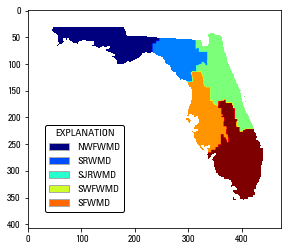

In [18]:
fname = r'..\ancillary\wmd_cd.ref'
wmd = np.loadtxt(fname)

# Define some labels for the district codes
label_dict = {1: 'NWFWMD',
              2: 'SRWMD',
              3: 'SJRWMD',
              4: 'SWFWMD',
              5: 'SFWMD'}

# Ignore zeros
wmd = np.ma.masked_equal(wmd, 0)

# Get the unique values in the array and
# feed them into the colormap function
# defined above
values = np.unique(wmd)
cmap, norm = discrete_colormap(values)

# Plot the districts array
im = plt.imshow(wmd, cmap=cmap)

# Create a legend using the defined values
# and labels
legend_elements = [Patch(facecolor=cmap(norm(k)), edgecolor='darkgrey', label=v) for k, v in label_dict.items()]
legend = plt.legend(handles=legend_elements,
                   bbox_to_anchor=(.05, .05),
                   loc='lower left', 
                   frameon=True, 
                   facecolor='white',
                   edgecolor='k',
                   framealpha=1.,
                   title='EXPLANATION')
legend.set_zorder(102)

plt.show()

Next, read the NetCDF file.

**NOTE:** the input NetCDF file `data\fl.et.2019.v.0.1.nc` is not provided in this repository. Please download the file separately and place in the `data\` directory or update the code block below to reflect the location of the file on your system.

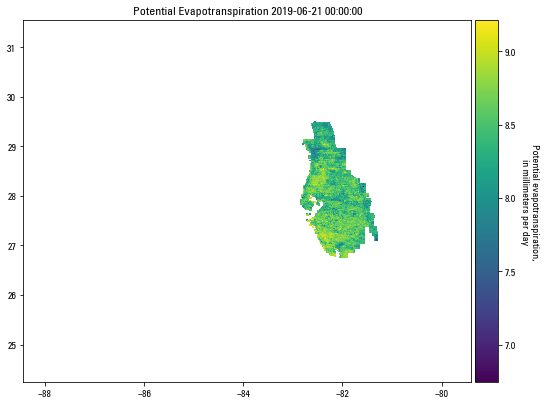

In [27]:
# Read only the 172nd day -- Python is zero-indexed, meaning
# that the first item is 0, the second item is 1, etc.
idx = 171

fname = r'data\fl.et.2019.v.1.0.nc'
with netcdf.Dataset(fname, 'r') as nc:
    date = nc.variables['time'][idx]
    lat = nc.variables['lat'][:]
    lon = nc.variables['lon'][:]
    pet = nc.variables['PET'][idx]

# Subset the potential ET array
# keep = [1, 3, 4]  # Northwest, St. Johns, and Southwest
keep = [4]  # Southwest only

# Not really slicing the data, just masking out values we are 
# not interested in.
mask = np.logical_not(np.isin(wmd, keep))

# Apply the mask over the plotable PET data
plotable = np.ma.masked_where(mask, pet)


# Plot the masked PET data array
fig = plt.figure(figsize=(8.5, 11))

ax = fig.add_subplot(111, aspect='equal')

ax.set_title(f'Potential Evapotranspiration {date}')
xx, yy = np.meshgrid(lon, lat)
quadmesh = ax.pcolormesh(xx, yy, plotable)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size='5%', pad=.05)
cb = plt.colorbar(quadmesh, cax=cax)
cb.ax.set_ylabel('Potential evapotranspiration,\nin millimeters per day', rotation=-90, va="bottom")

plt.show()